In [ ]:
import torch
from torch import nn, optim # Sets of preset layers and optimizers
import torch.nn.functional as F # Sets of functions such as ReLU
import torchvision as tv
# Step 1: Let's import some libraries!
import torch.nn as nn
import torchvision
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
from tqdm import tqdm
from torchvision import datasets, transforms # Popular datasets, architectures and common image transformations for computer vision
from sklearn.metrics import accuracy_score

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
def load_mnist(batch_size=32, train=True):

    '''
    Using the dataset and dataloader classes you should be able to make an MNIST set and loader
    the loader should use the 'batch_size' argument and the dataset should use'train'

    Also, the 'ToTensor' transform is given, you should set the transform of the dataset to just this
    '''
    to_tensor_transform = torchvision.transforms.ToTensor()
    dataset = {
        'train_data' : torchvision.datasets.MNIST(
            root = "./data",
            train = train,
            transform = to_tensor_transform,
            download = True, ),
        'test_data' : torchvision.datasets.MNIST(
            root = "./data",
            train = False,
            transform = to_tensor_transform,
            download = True, )
    }
    dataloader = {
        'train':torch.utils.data.DataLoader(dataset["train_data"],
                           batch_size = batch_size,
                           shuffle = True ),
        'test':DataLoader(dataset["test_data"],
                          batch_size=batch_size,
                          shuffle= True)
    }

    return dataset, dataloader

In [ ]:
def plot_image_and_label(image, raw_output_from_model):

    '''
    Takes in an image and label and shows them using matplotlib
    this is used to visualize the data and also the outputs of our network
    '''

    plt.imshow(image)
    if type(raw_output_from_model) is not int:
        _,predicted = torch.max(raw_output_from_model,1)
#         Takes 1 highest number from the output
        plt.title("Best label = " + str(predicted.item()) + ", with Score: " + str(round(raw_output_from_model[0][predicted].item() * 100,2)))
    else:
        plt.title("Label = " + str(raw_output_from_model))
    plt.show()
    return

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([1, 28, 28]) ex_image.shape


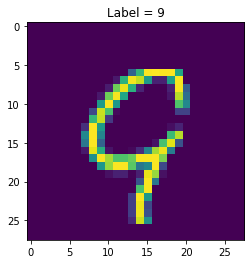

In [ ]:
# This will just test whether your dataset and loader work
# They might still have issues, but if an example image shows here you're on the right track!
train_data,train_dataloader = load_mnist(batch_size = 64, train = True)
ex_image, ex_label = train_data["train_data"][random.randint(0,1000)]
print(ex_image.shape,'ex_image.shape')
plot_image_and_label(ex_image.reshape(28,28), ex_label)

In [ ]:
#model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # (input_h - kernel_size + 2*padding )/stride +  1
        # (input_w - kernel_size + 2*padding )/stride +  1
        # 48*48
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=3,
                kernel_size=5,
                stride=1,
                padding=0,
            ),

            # 48 - 4  /2 + 1 =    23 : h, 23:w
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            #h = 12, w = 12
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels=5, kernel_size=4, stride=2, padding=2),
            # 7*7
            nn.ReLU(),
            nn.MaxPool2d(2),
            #3*3
        )
        # fully connected layer, output 2 classes
        self.out = nn.Linear(5 * 3 * 3, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        #print(x.shape)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(3, 5, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=45, out_features=2, bias=True)
)


In [ ]:
# #training
# from torch.autograd import Variable
# num_epochs = 2
# loss_func = nn.CrossEntropyLoss()
# optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
# batch_size=100
# train_dataset, train_dataloader = load_mnist(batch_size=batch_size, train=True)
# def train(num_epochs, cnn, loaders):

#     cnn.train()

#     # Train the model
#     total_step = len(train_dataloader['train'])

#     for epoch in range(num_epochs):
#         for i, (images, labels) in enumerate(loaders['train']):

#             # gives batch data, normalize x when iterate train_loader
#             b_x = Variable(images)   # batch x
#             b_y = Variable(labels)   # batch y
#             output = cnn(b_x)[0]
#             loss = loss_func(output, b_y)

#             # clear gradients for this training step
#             optimizer.zero_grad()

#             # backpropagation, compute gradients
#             loss.backward()
#             # apply gradients
#             optimizer.step()

#             if (i+1) % 100 == 0:
#                 print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
#                        .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
#                 pass

#         pass


#     pass
# train(num_epochs, cnn, train_dataloader)

IndexError: ignored

In [ ]:
def test():
    # Test the model
    test_dataset, test_dataloader = load_mnist(batch_size=batch_size, train=False)
    cnn.eval()
    accuracy = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for ex_image, ex_label in test_dataloader['test']:
            test_output, last_layer = cnn(ex_image)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()

            accuracy = (pred_y == ex_label).sum().item() / float(ex_label.size(0))

            pass
        print('Test Accuracy of the model on the 10000 test images: {}'.format(accuracy))
        pass
test()

Test Accuracy of the model on the 10000 test images: 0.13


In [ ]:
bits = []
def generateAllBinaryStrings(n, arr, i,num):
    if i == n:
        key = ''.join([str(i) for i in arr])
        bits.append(key)
        num += 1
        return

    # First assign "0" at ith position
    # and try for all other permutations
    # for remaining positions
    arr[i] = 0
    generateAllBinaryStrings(n, arr, i + 1,num+1)

    # And then assign "1" at ith position
    # and try for all other permutations
    # for remaining positions
    arr[i] = 1
    generateAllBinaryStrings(n, arr, i + 1,num+1)
num = 0
generateAllBinaryStrings(4,[0]*4 , 0,num)

In [ ]:
print(bits)
mapping = {}
curr_index = 0
invMapping = {}
for index,bit in enumerate(bits):
    mapping[index] = bit
    invMapping[bit] = index
print(mapping)
# Unbalanced : ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
# {0: '1111', 1: '0001', 2: '0010', 3: '0011', 4: '0100', 5: '0101', 6: '0110', 7: '0111', 8: '1000', 9: '1001' # Balanced :

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
{0: '0000', 1: '0001', 2: '0010', 3: '0011', 4: '0100', 5: '0101', 6: '0110', 7: '0111', 8: '1000', 9: '1001', 10: '1010', 11: '1011', 12: '1100', 13: '1101', 14: '1110', 15: '1111'}


In [ ]:
def training(modelname,model, loss_function, optimizer, train_dataloader, n_epochs, update_interval):

    '''
    Updates the parameters of the given model using the optimizer of choice to
    reduce the given loss_function

    This will iterate over the dataloader 'n_epochs' times training on each batch of images

    To get the gradient (which is stored internally in the model) use .backward() from the loss tensor
    and to apply it use .step() on the optimizer

    In between steps you need to zero the gradient so it can be recalculated -- use .zero_grad for this
    '''

    losses = []
    part_loss = []
    for n in range(n_epochs):
        for i, (image, label) in enumerate(tqdm(iter(train_dataloader["train"]))):

            # TODO Complete the training loop using the instructions above
            # Hint: the above code essentially does one training step

            ##############################################################
            optimizer.zero_grad()
            my_output = model(image)
            if modelname == 'model1':
                new_label = torch.Tensor([int(mapping[int(l)][0]) for l in label]).long()
            elif modelname == 'model2':
                new_label = torch.Tensor([int(mapping[int(l)][1]) for l in label]).long()
            elif modelname == 'model3':
                new_label = torch.Tensor([int(mapping[int(l)][2]) for l in label]).long()
            elif modelname == 'model4':
                new_label = torch.Tensor([int(mapping[int(l)][3]) for l in label]).long()
            elif modelname == 'model':
                new_label = label
            loss = loss_function(my_output,new_label)
            loss.backward()
            optimizer.step()
            part_loss.append(loss.item())
            ##############################################################

            if i % update_interval == 0:
                losses.append(sum(part_loss)/len(part_loss)) # This will append your losses for plotting -- please use "loss" as the name for your loss
#                 part_loss = []
    return model, losses

In [ ]:
print("testing the previously trained model on test dataset of MNIST")
ftest_dataset, test_dataloader = load_mnist(batch_size=10000, train=False)

testing the previously trained model on test dataset of MNIST


In [ ]:
def testing(modelname, model, loss_function, test_data):
    sum_loss = 0
    n_correct = 0
    total = 0
    for i, (image, label) in enumerate(tqdm(iter(test_data["test_data"]))):
        pred = model(image)
        if modelname == 'model1':
            new_label =  torch.Tensor([int(mapping[int(l)][0]) for l in label]).long()
        elif modelname == 'model2':
            new_label = torch.Tensor([int(mapping[int(l)][1]) for l in label]).long()
        elif modelname == 'model3':
            new_label = torch.Tensor([int(mapping[int(l)][2]) for l in label]).long()
        elif modelname == 'model4':
            new_label = torch.Tensor([int(mapping[int(l)][3]) for l in label]).long()
        elif modelname == 'model':
            new_label = label
        loss = loss_function(pred,new_label)
        sum_loss += loss.item()
        _, predicted = torch.max(pred,1)
        n_correct += (predicted == new_label).sum()
        total += new_label.size(0)

    test_acc = round(((n_correct / total).item() * 100), 2)
    avg_loss = round(sum_loss / len(test_data), 2)

    print("test accuracy:", test_acc)
    print("test loss:", avg_loss )

    return test_acc, avg_loss

In [ ]:
# Plug in your model, loss function, and optimizer
# Try out different hyperparameters and different models to see how they perform

lr = 0.0009          # The size of the step taken when doing gradient descent 0.01 0.001 0.0001
batch_size = 500        # The number of images being trained on at once
update_interval = 100   # The number of batches trained on before recording loss
n_epochs = 10           # The number of times we train through the entire dataset 5 10 15

train_dataset, train_dataloader = load_mnist(batch_size=batch_size, train=True)
model1 = CNN()
# model = MyMLP(784, 2)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)




In [ ]:
# Training Model 1

trained_model1, losses1 = training('model1',model1, optimizer, loss_function, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)

plt.plot(np.arange(len(losses1)) * batch_size * update_interval, losses1)
plt.title("training curve1")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()


  0%|          | 0/120 [00:00<?, ?it/s]


TypeError: ignored

In [ ]:
loss_function# Testing Model1
_,_ = testing('model1', trained_model1, loss_function, test_dataloader)


In [ ]:
#hyperparameter tuning model1
import math
def grid_search(model,input_shape,compression_size,test_data):
    """
    model : Trained model
    test_data : test data = dataset[30000//batch_size:]
    input_shape :input size of images
    compression_size :  size of bottleneck
    """
    e = math.e
    learning_rate = [0.0008,0.0009,0.00095]
    n_epochs_lst = [5,10,15]
    batch_size_lst = [200,300,500,800,1000]
    loss_function = nn.CrossEntropyLoss()
    accuracy = float('-inf')
    best_lr = 0
    update_interval = 100
    best_batch = 0
    best_n_epochs = 0
    for lr in learning_rate:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        for n_epochs in n_epochs_lst :
            trained_model, losses = training('model1',model, loss_function, optimizer, train_dataloader, n_epochs, update_interval)
            for batch_size in batch_size_lst:
                print(batch_size)
                print(lr)
                print(n_epochs)
                test_loss, test_accuracy = testing('model1', model, loss_function, test_dataloader)
                if test_accuracy >= accuracy:
                    best_lr = lr
                    best_batch = batch_size
                    best_n_epochs = n_epochs
                    accuracy = test_accuracy

    return best_lr , best_batch, best_n_epochs,test_accuracy

best_lr,best_batch_size, best_n_epochs,best_acc = grid_search(trained_model1, 784, 2, test_dataset)
print(best_lr,best_batch_size, best_n_epochs, best_acc)

In [ ]:
# lr = 0.0008      # The size of the step taken when doing gradient descent
# batch_size =500      # The number of images being trained on at once
# update_interval = 100   # The number of batches trained on before recording loss
# n_epochs = 10
# test_accuracy, test_loss = testing('model1', model, loss_function, test_dataloader)
# print(test_loss, test_accuracy)
# print(best_lr,loss,test_accuracy)

In [ ]:
lr = 0.0009       # The size of the step taken when doing gradient descent
batch_size = 1000  # The number of images being trained on at once
update_interval = 100   # The number of batches trained on before recording loss
n_epochs = 10         # The number of times we train through the entire dataset

train_dataset, train_dataloader = load_mnist(batch_size=batch_size, train=True)

model = MyMLP(784, 2)
loss_function = nn.CrossEntropyLoss()


In [ ]:
# Training Model 2
model2 = MyMLP(784, 2)
optimizer = torch.optim.Adam(model2.parameters(), lr=lr)
trained_model2, losses2 = training('model2',model2, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)

plt.plot(np.arange(len(losses2)) * batch_size * update_interval, losses2)
plt.title("training curve2")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()


In [ ]:
# Testing Model2
_,_ = testing('model2', trained_model2, loss_function, test_dataloader)


In [ ]:
# Model2 Hyperparameter Tuning
def grid_search(model,input_shape,compression_size,test_data):
    """
    model : Trained model
    test_data : test data = dataset[30000//batch_size:]
    input_shape :input size of images
    compression_size :  size of bottleneck
    """
    e = math.e
    learning_rate = [0.0008,0.0009,0.009,0.00001,0.001]
    n_epochs_lst = [5,10,8,3]
    batch_size_lst = [120,300,500,800,1000]
    loss_function = nn.CrossEntropyLoss()
    loss = float('inf')
    best_lr = 0
    update_interval = 100
    best_batch = 0
    best_n_epochs = 0
    for lr in learning_rate:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        for n_epochs in n_epochs_lst :
            trained_model, losses = training('model2',model, loss_function, optimizer, train_dataloader, n_epochs, update_interval)
            for batch_size in batch_size_lst:
                print(batch_size)
                print(lr)
                print(n_epochs)
                test_loss, test_accuracy = testing('model2', model, loss_function, test_dataloader)
                if test_loss <= loss:
                    best_lr = lr
                    best_batch = batch_size
                    best_n_epochs = n_epochs
                    loss = test_loss

    return best_lr , best_batch, best_n_epochs,loss

best_lr,best_batch_size, best_n_epochs,loss = grid_search(trained_model2, 784, 2, test_dataset)
print(best_lr,best_batch_size, best_n_epochs, loss)

In [ ]:
lr = 0.0008            # The size of the step taken when doing gradient descent
batch_size = 128        # The number of images being trained on at once
update_interval = 100   # The number of batches trained on before recording loss
n_epochs = 3            # The number of times we train through the entire dataset

train_dataset, train_dataloader = load_mnist(batch_size=batch_size, train=True)

model = MyMLP(784, 2)
loss_function = nn.CrossEntropyLoss()


In [ ]:
# Training Model 3
model3 = MyMLP(784, 2)
optimizer = torch.optim.Adam(model3.parameters(), lr=lr)
trained_model3, losses3 = training('model3',model3, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)

plt.plot(np.arange(len(losses3)) * batch_size * update_interval, losses3)
plt.title("training curve3")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()


In [ ]:
# Testing Model3
_,_ = testing('model3' ,trained_model3, loss_function, test_dataloader)

In [ ]:
# Model3 Hyperparameter Tuning
def grid_search(model,input_shape,compression_size,test_data):
    """
    model : Trained model
    test_data : test data = dataset[30000//batch_size:]
    input_shape :input size of images
    compression_size :  size of bottleneck
    """
    e = math.e
    learning_rate = [0.0008,0.0009,0.00095,0.0001]
    n_epochs_lst = [5,10,15]
    batch_size_lst = [500,800,1000,1300,1500]
    loss_function = nn.CrossEntropyLoss()
    loss = float('inf')
    best_lr = 0
    update_interval = 100
    best_batch = 0
    best_n_epochs = 0
    for lr in learning_rate:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        for n_epochs in n_epochs_lst :
            trained_model, losses = training('model3',model, loss_function, optimizer, train_dataloader, n_epochs, update_interval)
            for batch_size in batch_size_lst:
                print(batch_size)
                print(lr)
                print(n_epochs)
                test_loss, test_accuracy = testing('model3', model, loss_function, test_dataloader)
                if test_loss <= loss:
                    best_lr = lr
                    best_batch = batch_size
                    best_n_epochs = n_epochs
                    loss = test_loss

    return best_lr , best_batch, best_n_epochs,loss

best_lr,best_batch_size, best_n_epochs,loss = grid_search(trained_model3, 784, 2, test_dataset)
print(best_lr,best_batch_size, best_n_epochs, loss)

In [ ]:
lr = 0.0008            # The size of the step taken when doing gradient descent
batch_size = 128        # The number of images being trained on at once
update_interval = 100   # The number of batches trained on before recording loss
n_epochs = 3            # The number of times we train through the entire dataset

train_dataset, train_dataloader = load_mnist(batch_size=batch_size, train=True)

model4 = MyMLP(784, 2)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=lr)

In [ ]:
#  Training Model 4
trained_model4, losses4 = training('model4',model4, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)
plt.plot(np.arange(len(losses4)) * batch_size * update_interval, losses4)
plt.title("training curve4")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()


In [ ]:
# Testing Model4
_,_ = testing('model4', trained_model4, loss_function, test_dataloader)

In [ ]:
# Model4 Hyperparameter Tuning
def grid_search(model,input_shape,compression_size,test_data):
    """
    model : Trained model
    test_data : test data = dataset[30000//batch_size:]
    input_shape :input size of images
    compression_size :  size of bottleneck
    """
    e = math.e
    learning_rate = [0.0008,0.0009,0.00095,0.0001]
    n_epochs_lst = [3,5]
    batch_size_lst = [500,800,1000,1300,1500]
    loss_function = nn.CrossEntropyLoss()
    loss = float('inf')
    best_lr = 0
    update_interval = 100
    best_batch = 0
    best_n_epochs = 0
    for lr in learning_rate:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        for n_epochs in n_epochs_lst :
            trained_model, losses = training('model3',model, loss_function, optimizer, train_dataloader, n_epochs, update_interval)
            for batch_size in batch_size_lst:
                print(batch_size)
                print(lr)
                print(n_epochs)
                test_loss, test_accuracy = testing('model3', model, loss_function, test_dataloader)
                if test_loss <= loss:
                    best_lr = lr
                    best_batch = batch_size
                    best_n_epochs = n_epochs
                    loss = test_loss

    return best_lr , best_batch, best_n_epochs,loss

best_lr,best_batch_size, best_n_epochs,loss = grid_search(trained_model4, 784, 2, test_dataset)
print(best_lr,best_batch_size, best_n_epochs, loss)

In [ ]:
def train_and_test(modelname,model, loss_function, optimizer, batch_size, update_interval, n_epochs):

    '''
    This will use your/my methods to create a dataloader, train a gven model, and then test its performance

    Again, since I gave this to you for free you have to promise to look at it and try to understand it
    '''

    _, train_dataloader = load_mnist(batch_size=batch_size, train=True)
    trained_model, losses = training(modelname,model, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)

    # Specify a path
    PATH = "state_dict_{}.pt".format(modelname)

    # Save
    torch.save(trained_model.state_dict(), PATH)
    _, test_dataloader = load_mnist(batch_size=10000, train=False)
    test_acc, test_loss = testing(modelname, trained_model, loss_function, test_dataloader)

    plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses, color="b", label="train loss")
    plt.hlines(test_loss, 0, len(losses) * batch_size * update_interval, color='r', label="test loss")
    plt.legend()
    plt.title("training curve")
    plt.xlabel("number of images trained on")
    plt.ylabel("loss")
    plt.savefig('lr{} Single Model test_acc{} test_loss{}.png'.format(0.08,test_acc,test_loss))
    plt.show()

    return trained_model, test_loss



In [ ]:
# Getting Train and Test for the BASELINE Model
lr = 0.06               # The size of the step taken when doing gradient descent
batch_size = 100      # The number of images being trained on at once
update_interval = 400      # The number of times we train through the entire dataset
model = MyMLP(784, 10)
n_epochs = 10
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

_, _ = train_and_test('model',model, loss_function, optimizer, batch_size=batch_size, update_interval=update_interval, n_epochs=n_epochs)

In [ ]:
# # https://stackoverflow.com/questions/63975130/how-to-get-only-specific-classes-from-pytorchs-fashionmnist-dataset
# dataset_full = train_dataset
# #Selecting classes 7, 2, 5 and 6
# idx = (dataset_full.targets==7) | (dataset_full.targets==2) | (dataset_full.targets==5) | (dataset_full.targets==6)
# dataset_full.targets = dataset_full.targets[idx]
# dataset_full.data = dataset_full.data[idx]

In [ ]:
#  EXPERIMENT 1 :
def experiment_1(model):
    """
    Train 4 similar models on different parts of the MNIST dataset and combine the output
    Same HyperParameters for every model
    """
    lr = 0.08               # The size of the step taken when doing gradient descent
    batch_size = 100       # The number of images being trained on at once
    update_interval = 100   # The number of batches trained on before recording loss
    n_epochs = 30  # The number of times we train through the entire dataset
#     Train and Test 4 different models
    model1 = MyMLP(784, 1)
    model2 = MyMLP(784, 1)
    model3 = MyMLP(784, 1)
    model4 = MyMLP(784, 1)

experiment_1(MyMLP)

In [ ]:
# Experiment 2:
def experiment_1(self, model):
    """
    Train 4 similar models on different parts of the MNIST dataset and combine the output
    Same HyperParameters for every model
    """
    lr = 0.08               # The size of the step taken when doing gradient descent
    batch_size = 100       # The number of images being trained on at once
    update_interval = 100   # The number of batches trained on before recording loss
    n_epochs = 30  # The number of times we train through the entire dataset
#     Train and Test 4 different models
    model1 = MyMLP(784, 2)
    model2 = MyMLP(784, 2)
    model3 = MyMLP(784, 2)
    model4 = MyMLP(784, 2)

    loss_function = nn.BCELoss()
#     Binary Cross Entropy loss
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    _, _ = train_and_test(model1, loss_function, optimizer, batch_size=batch_size, update_interval=update_interval, n_epochs=n_epochs)


In [ ]:
#  Change the labels
# Have 4 modules : if module 1 : change the label to 0 if it is in say group [2,3,4,5,6] , if not make it output a 1
# Create 4 modules like this
# And Map each output 0 and 1 for each module to a unique number
# {9 : 1111}

In [ ]:
# Train 1 model to predict 4 different ways
# Recurrent Predictions into Groups :
# Group 1 : [0 -5][5-9]
# Say the model selects [5-9]
# Now make the model predict [5-7] and [8-9] as groups
#  keep splitting things until you get 1 prediciton  == label

In [ ]:
# def training():
# "Final String " 0111 :  9
# input(0,1,1,1)
# new_label = 9 .convert(binary)
# class MyEnsemble(nn.Module):
#     def __init__(self, outA, outB, outC, outD,input_shape):
#         super(MyEnsemble, self).__init__()
#         self.lin1 = nn.Linear(inpt_shape,1)
#     def forward(self, x):
#         return self.lin1(x)

# modelA = MyModelA()
# modelB = MyModelB()
# # Load state dicts
# modelA.load_state_dict(torch.load(PATH))
# modelB.load_state_dict(torch.load(PATH))

# model = MyEnsemble(modelA, modelB)
# x1, x2 = torch.randn(1, 10), torch.randn(1, 20)
# output = model(x1, x2)

In [ ]:
lr = 0.008            # The size of the step taken when doing gradient descent
batch_size = 1        # The number of images being trained on at once
update_interval = 300   # The number of batches trained on before recording loss
n_epochs = 3            # The number of times we train through the entire dataset

train_dataset, train_dataloader = load_mnist(batch_size=batch_size, train=True)

model = MyMLP(784, 2)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
def new_training(train_dataloader, n_epochs, update_interval):
    acc = []
    part_loss = []
    num_correct = 0
    for n in range(n_epochs):
        for i, (image, label) in enumerate(tqdm(iter(train_dataloader))):

            # TODO Complete the training loop using the instructions above
            # Hint: the above code essentially does one training step
            ##############################################################
            out1 = trained_model1(image)
            out2 = trained_model2(image)
            out3 = trained_model3(image)
            out4 = trained_model4(image)
            res = []
            for i in range(len(out1)):
              a = str(torch.argmax(out1[i]).numpy()) + str(torch.argmax(out2[i]).numpy()) + str(torch.argmax(out3[i]).numpy()) + str(torch.argmax(out4[i]).numpy())
              res.append(int(a))
            # print(res)
            my_output = res
            new_label = torch.Tensor([int(mapping[int(l)]) for l in label]).long()
            num_correct = 0
            # print(new_label)
            for index in range(len(new_label)):
              if my_output[index] == new_label[index] :
                num_correct = num_correct + 1

            acc.append(num_correct/len(new_label))
            ##############################################################
    return acc

In [ ]:
_, train_dataloader = load_mnist(batch_size=batch_size, train=True)
new_training(train_dataloader["train"], 10, 300)

  0%|          | 0/120 [00:00<?, ?it/s]


NameError: ignored

In [ ]:
#testing
_, train_dataloader = load_mnist(batch_size=batch_size, train=True)
acc = new_training(train_dataloader, 3, 300)
plt.plot(acc)
plt.title("Combined Labels of 4 Models Plot of Accuracy with Test Dataset")
plt.xlabel("number of images trained on")
plt.ylabel(" Train Accuracy")
final_accuracy = acc[-1]
print("final accuracy" ,final_accuracy)

In [ ]:
#   Balanced Data (Li and etc) vs Our Binary mapping right now
#   no of epochs should be less
#  Testing Accuracy , Learning Curve
#  Also how will the model perform if given 1000  Exampls, vs 6000 Examples etc .
# Compare this to the baseline model

# Train 4 models indvidually
# Just test the model with combination of outputs of 4 models(no training required, just combine the outputs)

In [ ]:
# The model Capability may not be enough : Try the Same with ResNets

In [ ]:
#  Group similar numbers together and test it out